```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018 Norwegian Meteorological Institute

This notebook implements a test to investigate power consumption for
different block sizes for selected numerical schemes.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Power consumption: Block Size Experiment

This notebook runs some iterations of each of different numerical schemes on a range of different CUDA block sizes.
The 'nvidia-smi' application runs in the background and records various parameters, such as GPU power consumption, core temperature, etc, and reports these parameters to a log file. 
The performance is simultaneously reported in a text file.
These parameters are later read and processed to obtain the most efficient block sizes on the GPU on your given system.

### To look at the results shown in the paper
Execute the cells below to read the results obtained for the paper and reproduce the power consumption results.

### To find your own power consumption
Comment out the second to last line in the second cell (which overwrites the `test_filename` variable) in order to produce your own benchmark results. Optimal block sizes are typically not the same across different GPUs, so your results might differ from those reported in the paper.


In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import subprocess
import os
import socket
import os.path
import time
from tempfile import TemporaryFile


import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
# Generate unique folder name
folder_name = os.path.abspath("power_block_size_0")
folder_test = 0
while (os.path.isdir(folder_name)):

    folder_name = os.path.abspath("power_block_size_" + str(folder_test))
    folder_test += 1
    
    
#Use the existing file, do not generate new data
#folder_name = os.path.abspath("power_block_size_0")

print("Storing data in folder " + folder_name)
main_log_filename='power_consumptions.log'

Storing data in folder /home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_1


In [3]:
# Specify python command:
#python = "python"

python = 'python3'
if socket.gethostname().startswith('havahol'):
    python = "/home/havahol/miniconda3/envs/gpuocean/bin/python"
shell = False
print(python)

/home/havahol/miniconda3/envs/gpuocean/bin/python


In [4]:
# benchmark duration parameter
steps_per_iteration_benchmark = 100

# nvidia-smi parameters:
smi_loop_ms = 50
sleep_duration_sec = 3

# derived parameters:
smi_entries_per_sec = round(1000/smi_loop_ms) # Number of smi log entries per second
num_entries_to_ignore = smi_entries_per_sec*sleep_duration_sec 



In [5]:
def runBenchmark(folder_name):
    #sim = np.array(["FBL", "CTCS", "KP", "CDKLM"])
    #sim = np.array(["CDKLM", "CTCS", "FBL", "KP"])
    sim = np.array(["CDKLM", "FBL", "CTCS"])
    block_width = np.array([4, 8, 12, 16, 24, 32])
    block_height = np.array([4, 8, 12, 16, 24, 32])
    #block_width = np.array([12, 16, 24])#, 8]), #12, 16, 24, 32])
    #block_height = np.array([12, 16, 24])#, 8]) #, 12, 16, 24, 32])
    #block_width=list(range(2,33,1))
    #block_height=list(range(2,33,1))
    
    print("Running with the following:")
    print('Sims: ' + str(sim))
    print("Widths: " + str(block_width))
    print("Heights: " + str(block_height))

    block_width, block_height = np.meshgrid(block_width, block_height)
    
    test_filename = os.path.join(folder_name, main_log_filename)
    
    
    with open(test_filename, 'w') as test_file:
        for k in range(len(sim)):
            test_file.write("##########################################################################\n")
            test_file.write("Using simulator " + sim[k] + ".\n")
            test_file.write("##########################################################################\n")

            
            for j in range(block_width.shape[1]):
                for i in range(block_width.shape[0]):
                    

                    start_info = sim[k] + " [{:02d} x {:02d}]\n".format(block_width[i,j], block_height[i,j])
                    test_file.write("=========================================\n")
                    test_file.write(start_info)
                    test_file.write("-----------------------------------------\n")
                    print('\n'+start_info)
                    
                    with TemporaryFile() as tmpfile:

                        # Start nvidia-smi to file f
                        smi_report_filename = 'nvidia_smi_'+sim[k]+'_w'+str(block_width[i,j])+'_h'+str(block_height[i,j])+'.log'
                        smi_report_file = os.path.join(folder_name, smi_report_filename)

                        print('')
                        smi_cmd = [
                            'nvidia-smi',
                            '--query-gpu=timestamp,'+\
                                        'temperature.gpu,'+\
                                        'memory.free,'+\
                                        'fan.speed,'+\
                                        'utilization.gpu,'+\
                                        'power.draw,'+\
                                        'clocks.current.sm,'+\
                                        'clocks.current.graphics,'+\
                                        'clocks.current.memory',
                            '--format=csv',
                            '--loop-ms='+str(smi_loop_ms),
                            '--filename='+str(smi_report_file)
                        ]
                        test_file.write("=========================================\n")
                        test_file.write('nvidia_smi_file='+str(smi_report_file)+', ')
                        test_file.write('nvidia_smi_cmd='+str(smi_cmd)+', ')
                        print('nvidia_smi_file='+str(smi_report_file))

                        smi_process = subprocess.Popen(smi_cmd, shell=shell, 
                                                       stdin=subprocess.PIPE, 
                                                       stdout=tmpfile, 
                                                       stderr=subprocess.STDOUT)


                        # Sleep 3 sec
                        time.sleep(sleep_duration_sec)

                        # Run benchmark
                        print('starting benchmark... ', end='')
                        tic = time.time()

                        cmd = [ python, "run_benchmark.py", 
                               "--block_width", str(block_width[i,j]), "--block_height", str(block_height[i,j]),
                               "--simulator", sim[k], #, "--nx", "100", "--ny", "100", 
                               "--steps_per_download", str(steps_per_iteration_benchmark), 
                               "--iterations", "10"]
                        p = subprocess.Popen(cmd, shell=shell, 
                                             stdin=subprocess.PIPE, 
                                             stdout=subprocess.PIPE, 
                                             stderr=subprocess.STDOUT)

                        # process output from run benchmark
                        output = p.stdout.read()
                        test_file.write(str(output) + "\n")
                        test_file.write("=========================================\n")
                        test_file.write("\n")
                        print('benchmark finished!')

                        toc = time.time()

                        # Sleep 3 sec
                        time.sleep(sleep_duration_sec)

                        # Kill nvidia-smi process.
                        smi_process.terminate()
                    
                    
                    infostr = sim[k] + " [{:02d} x {:02d}] completed in {:.02f} s\n".format(block_width[i,j], block_height[i,j], (toc-tic))
                    test_file.write(infostr)
                    print(infostr)
                    
            test_file.write("\n\n\n")
            test_file.flush()
            os.fsync(test_file)

# Generate unique folder name
folder_name = os.path.abspath("power_block_size_0")
folder_test = 0
while (os.path.isdir(folder_name)):

    folder_name = os.path.abspath("power_block_size_" + str(folder_test))
    folder_test += 1
            

#folder_name = os.path.abspath("power_block_size_14")
#folder_name = os.path.abspath("amazon_v100/power_block_size_1/")
folder_name = os.path.abspath("met_p100/power_block_size_1/")
if not (os.path.isdir(folder_name)):
    os.mkdir(folder_name)
    runBenchmark(folder_name)
    print('Done!')
else:
    print("Using existing run in " + folder_name)

Using existing run in /home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/met_p100/power_block_size_1


In [6]:
dataframe_columns = ['simulator', 'block_width', 'block_height', 
                     'megacells',
                     'max_temperature', 'min_temperature', 'cumsum_temperature',
                     'max_power', 'min_power', 'total_power', 'mean_power',
                     'max_utilization', 'min_utilization', 'mean_utilization',
                     'megacells_per_joule'
                     ]
labels = ['simulator', 'block_width', 'block_height', 
          'Megacells/s',
          'Max temperature [C]', 'Min temperature [C]', 'Accumulated temperature [Cs]',
          'Max power consumption [W]', 'Min power consumption [W]', 
          'Energy consumption [J]', 'Mean power consumption [W]',
          'Max GPU utilization [%]', 'Min GPU utilization [%]', 'Mean GPU utilization [%]',
          'Megacells per Joule'
         ]


def read_smi_file(smi_log_file):
    smi_log = pd.read_csv(smi_log_file)
    temp_key  = 'temperature.gpu'
    power_key = 'power.draw [W]'
    utilization_key = 'utilization.gpu [%]'
    fan_key = 'fan.speed [%]'
    
    # Remove whitespaces from column names:
    smi_log.rename(columns=lambda x: x.strip(), inplace=True)

    #for col in smi_log.columns:
    #    print(col)
        
    # Parse missing values
    smi_log = smi_log.replace(' [Not Supported]', np.NaN)
    
    # Helper function for parcing percent values
    def parse_value(df, key, unit):
        if not pd.isnull(df[key].iloc[0]):
            #print('fixing ' + key)
            df[key] = df[key].str.replace(' ','')
            df[key] = df[key].str.replace(unit, '')
            df[key] = pd.to_numeric(smi_log[key])
            
    parse_value(smi_log, utilization_key, '%')
    parse_value(smi_log, fan_key, '%')
    parse_value(smi_log, power_key, 'W')
    
    # Find min and max 
    max_temperature = smi_log[temp_key].max()
    min_temperature = smi_log[temp_key].min()
    min_power_draw  = smi_log[power_key].min()
    max_power_draw  = smi_log[power_key].max()
    min_utilization = smi_log[utilization_key].min()
    max_utilization = smi_log[utilization_key].max()
    
    # temperature*seconds
    all_sum_temperature = smi_log[temp_key].sum()*smi_loop_ms/1000

    # Drop first and last rows
    # This compensates for the sleep commands above.
    smi_log.drop(smi_log.head(num_entries_to_ignore).index,inplace=True)
    smi_log.drop(smi_log.tail(num_entries_to_ignore).index,inplace=True)
    
    cumsum_temperature = smi_log[temp_key].sum()*smi_loop_ms/1000
    
    total_power = (smi_log[power_key]-min_power_draw).sum()*smi_loop_ms/1000
    if np.isnan(max_power_draw) and np.isnan(min_power_draw):
        total_power = np.NaN
    mean_power = smi_log[power_key].mean()-min_power_draw
    mean_utilization = smi_log[utilization_key].mean()
    
    # All these experiements use the same number of iterations,
    # hence, relative megacells_per_joule = 1/total_power
    rel_megacells_per_joule = 1/total_power
    
    computed_megacells = 2048*2048*100*10e-6
    megacells_per_joule = computed_megacells/total_power
    
    
    ### TODO! Multiply with the appropriate number of megacells = nx*ny*steps_per_download*iterations
        
    df_values = {'max_temperature': max_temperature,
                 'min_temperature': min_temperature,
                 'cumsum_temperature': cumsum_temperature,
                 'max_power': max_power_draw,
                 'min_power': min_power_draw,
                 'total_power': total_power,
                 'mean_power': mean_power,
                 'max_utilization': max_utilization,
                 'min_utilization': min_utilization,
                 'mean_utilization': mean_utilization,
                 'megacells_per_joule': megacells_per_joule
                }
    
    return df_values


def getData(filename):
    # State variables
    simulator = None
    block_width = None
    megacells = None
    block_height = None
    #max_temperature = None
    #min_temperature = None
    #cumsum_temperature = None
    #power_draw = None
    
    
    df = pd.DataFrame(columns = dataframe_columns)
    
    with open(filename) as origin_file:
        for line in origin_file:
            line = str(line)
            
            # Find simulator
            match = re.match('Using simulator (.+)\.', line)
            if match:
                simulator = match.group(1)
                
            if simulator == None:
                continue

            # Find block size
            match = re.match(simulator + ' \[(\\d+) x (\\d+)\]$', line)
            if match:
                block_width = match.group(1)
                block_height = match.group(2)
                
            # Find simulator megacells
            match = re.match('.*Maximum megacells: (\\d+(\.\\d+)?)', line)
            if match:
                megacells = match.group(1)
                
            # Find nvidia-smi report
            match = re.match('nvidia_smi_file=(.+).log,', line)
            if match:
                smi_log_file = os.path.abspath(match.group(1)+'.log')

                # In case the experiment was run on a different computer than this
                if not os.path.isfile(smi_log_file):
                    smi_log_filename = os.path.split(smi_log_file)[-1]
                    potential_folder = os.path.split(filename)[0]
                    smi_log_file = os.path.join(potential_folder, smi_log_filename)

                assert os.path.isfile(smi_log_file), 'Did not find smi_log_file ' +  str(smi_log_file)
           
                df_entries = {'simulator': simulator,
                              'block_width': block_width,
                              'block_height': block_height,
                              'megacells': megacells}
                
                df_smi_entries = read_smi_file(smi_log_file)
                df_entries.update(df_smi_entries)
                
                df = df.append(df_entries , ignore_index=True)
                
                
                
                
                block_width = None
                block_height = None
                #max_temperature = None 
                #min_temperature = None
                #cumsum_temperature = None
                megacells = None
                #simulator = None
            
    return df

main_log_file = os.path.join(folder_name, main_log_filename)
df = getData(main_log_file)
df


,simulator,block_width,block_height,megacells,max_temperature,min_temperature,cumsum_temperature,max_power,min_power,total_power,mean_power,max_utilization,min_utilization,mean_utilization,megacells_per_joule
0,CDKLM,04,04,831.34777640,42,28,1832.85,126.24,30.14,4358.0260,88.848644,100,0,94.512742,0.962432
1,CDKLM,04,08,1335.90939517,46,37,1286.30,142.71,32.32,3119.7575,105.042340,100,0,96.855219,1.344433
2,CDKLM,04,12,1291.24979389,48,40,1413.05,145.85,33.05,3282.0950,106.216667,100,0,96.236246,1.277935
3,CDKLM,04,16,1440.59441451,48,41,1291.60,143.91,32.81,2924.2090,105.758011,100,0,96.540687,1.434338
4,CDKLM,04,24,1456.05439292,49,42,1295.05,141.83,33.30,2841.6720,103.145989,100,0,95.989111,1.475999
5,CDKLM,04,32,1491.67580818,49,42,1262.75,141.58,33.05,2763.5830,103.311514,100,0,96.244860,1.517705
6,CDKLM,08,04,1454.20361367,50,42,1328.15,152.26,33.78,3095.3855,112.355191,100,0,95.860254,1.355018
7,CDKLM,08,08,1654.69530766,50,43,1171.60,154.19,33.30,2774.3915,115.119979,100,0,96.188797,1.511792
8,CDKLM,08,12,1726.77288724,50,43,1142.05,154.19,33.78,2661.0650,113.478252,100,0,94.855011,1.576175
9,CDKLM,08,16,1755.67652705,50,43,1110.20,152.98,33.54,2586.6995,113.701077,100,0,95.973626,1.621489


['04' '08' '12' '16' '24' '32']
Plotting megacells
         04       08       12       16       24       32
04  831.348  1335.91  1291.25  1440.59  1456.05  1491.68
08   1454.2   1654.7  1726.77  1755.68  1756.31  1744.41
12  1375.18  1761.48  1728.03  1846.66  1742.19  1751.67
16  1732.19  1914.01  1953.72  1932.75   1858.5  1824.96
24  1742.75  1959.05  1891.74  1890.83  1620.46  1774.08
32  1857.02  2038.29  2002.17  1967.42  1898.98  1553.88
         04       08       12       16       24       32
04  831.348  1335.91  1291.25  1440.59  1456.05  1491.68
08   1454.2   1654.7  1726.77  1755.68  1756.31  1744.41
12  1375.18  1761.48  1728.03  1846.66  1742.19  1751.67
16  1732.19  1914.01  1953.72  1932.75   1858.5  1824.96
24  1742.75  1959.05  1891.74  1890.83  1620.46  1774.08
32  1857.02  2038.29  2002.17  1967.42  1898.98  1553.88
Maximum=2038.29
Minimum=831.35
Mean=1709.91
/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/met_p100/power_block_size_

/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/met_p100/power_block_size_1/total_power_CDKLM.pdf
         04       08       12       16       24       32
04  1174.82  841.268  927.804   847.18  786.951  841.971
08  812.119  729.188  744.049  738.549  691.318  742.521
12  825.281  682.122  735.933  685.445  653.546  707.583
16  689.899  619.664  615.866  636.185   621.04  672.516
24  691.779  617.412  657.417  646.262   621.37  682.999
32  657.055  587.656  623.577  610.571   582.61  628.792
         04       08       12       16       24       32
04  1174.82  841.268  927.804   847.18  786.951  841.971
08  812.119  729.188  744.049  738.549  691.318  742.521
12  825.281  682.122  735.933  685.445  653.546  707.583
16  689.899  619.664  615.866  636.185   621.04  672.516
24  691.779  617.412  657.417  646.262   621.37  682.999
32  657.055  587.656  623.577  610.571   582.61  628.792
Maximum=1174.82
Minimum=582.61
Mean=711.95
/home/havahol/playground/gpu

/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/met_p100/power_block_size_1/min_utilization_FBL.pdf
Plotting mean_utilization
         04       08       12       16       24       32
04  94.5127  96.8552  96.2362  96.5407  95.9891  96.2449
08  95.8603  96.1888   94.855  95.9736  94.7852  96.1089
12  96.0911  95.8945  95.2655  95.6521  95.1401  96.0241
16  95.1974  95.6516  94.1466  95.5288  95.7083  94.7416
24  96.1373  94.3494  95.6934  95.4918  95.1888  95.6203
32  94.6651  95.3528  95.4925  94.3947  95.4141  96.1945
         04       08       12       16       24       32
04  94.5127  96.8552  96.2362  96.5407  95.9891  96.2449
08  95.8603  96.1888   94.855  95.9736  94.7852  96.1089
12  96.0911  95.8945  95.2655  95.6521  95.1401  96.0241
16  95.1974  95.6516  94.1466  95.5288  95.7083  94.7416
24  96.1373  94.3494  95.6934  95.4918  95.1888  95.6203
32  94.6651  95.3528  95.4925  94.3947  95.4141  96.1945
Maximum=96.86
Minimum=94.15
Mean=95.53
/hom

/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/met_p100/power_block_size_1/mean_utilization_CTCS.pdf
         04       08       12       16       24       32
04   91.163  87.8313  87.5449  86.9366  82.5347  85.8309
08  87.0784   84.952  83.9833  80.2893  84.3333       84
12  86.8014  83.5982  79.7107  82.4037  81.8727  82.9557
16  82.6068  78.1182  81.8077  81.1765  81.8692  81.7143
24   80.025  83.0094  81.9429  82.0926  82.8103  81.4409
32   82.973  81.2157  81.6286  82.0485  80.3771  82.4907
         04       08       12       16       24       32
04   91.163  87.8313  87.5449  86.9366  82.5347  85.8309
08  87.0784   84.952  83.9833  80.2893  84.3333       84
12  86.8014  83.5982  79.7107  82.4037  81.8727  82.9557
16  82.6068  78.1182  81.8077  81.1765  81.8692  81.7143
24   80.025  83.0094  81.9429  82.0926  82.8103  81.4409
32   82.973  81.2157  81.6286  82.0485  80.3771  82.4907
Maximum=91.16
Minimum=78.12
Mean=83.14


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/met_p100/power_block_size_1/mean_utilization_FBL.pdf
Plotting megacells_per_joule
          04       08       12       16       24       32
04  0.962432  1.34443  1.27794  1.43434    1.476  1.51771
08   1.35502  1.51179  1.57617  1.62149  1.65094  1.66978
12   1.27711   1.5813  1.59061   1.6959   1.7033  1.74049
16   1.52985  1.69989  1.75963  1.80375  1.83367  1.84801
24   1.55598  1.74126   1.7909  1.83855  1.79932  1.86676
32   1.67787  1.86725  1.91253  1.96235  1.93293  1.96927
          04       08       12       16       24       32
04  0.962432  1.34443  1.27794  1.43434    1.476  1.51771
08   1.35502  1.51179  1.57617  1.62149  1.65094  1.66978
12   1.27711   1.5813  1.59061   1.6959   1.7033  1.74049
16   1.52985  1.69989  1.75963  1.80375  1.83367  1.84801
24   1.55598  1.74126   1.7909  1.83855  1.79932  1.86676
32   1.67787  1.86725  1.91253  1.96235  1.93293  1.96927
Maximum=1.97
Minimum=0.96

/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/met_p100/power_block_size_1/megacells_per_joule_CDKLM.pdf
         04       08       12       16       24       32
04  3.57017   4.9857  4.52068   4.9509  5.32981  4.98153
08  5.16464  5.75202  5.63714  5.67911  6.06712  5.64873
12  5.08228   6.1489   5.6993   6.1191  6.41776  5.92765
16  6.07959  6.76867  6.81042  6.59291  6.75368  6.23673
24  6.06307  6.79336  6.37998   6.4901  6.75009  6.14101
32  6.38349  7.13734   6.7262  6.86948  7.19916  6.67042
         04       08       12       16       24       32
04  3.57017   4.9857  4.52068   4.9509  5.32981  4.98153
08  5.16464  5.75202  5.63714  5.67911  6.06712  5.64873
12  5.08228   6.1489   5.6993   6.1191  6.41776  5.92765
16  6.07959  6.76867  6.81042  6.59291  6.75368  6.23673
24  6.06307  6.79336  6.37998   6.4901  6.75009  6.14101
32  6.38349  7.13734   6.7262  6.86948  7.19916  6.67042
Maximum=7.20
Minimum=3.57
Mean=6.01


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/met_p100/power_block_size_1/megacells_per_joule_CTCS.pdf
         04       08       12       16       24       32
04  3.57795  5.56387  5.75661   6.3391  6.29118   6.8782
08  6.02241  6.66638   7.3765  7.76824  7.99124  7.77908
12  5.92523  7.73338  7.91295  8.06725  8.44499  8.78582
16  7.32415  8.00693  8.48413  9.12481  9.25212  8.90561
24  7.26367  8.57455  8.78161  8.50288  8.72682  9.29402
32  8.00419  8.74148  9.11613  9.73396  9.87849  9.34569
         04       08       12       16       24       32
04  3.57795  5.56387  5.75661   6.3391  6.29118   6.8782
08  6.02241  6.66638   7.3765  7.76824  7.99124  7.77908
12  5.92523  7.73338  7.91295  8.06725  8.44499  8.78582
16  7.32415  8.00693  8.48413  9.12481  9.25212  8.90561
24  7.26367  8.57455  8.78161  8.50288  8.72682  9.29402
32  8.00419  8.74148  9.11613  9.73396  9.87849  9.34569
Maximum=9.88
Minimum=3.58
Mean=7.83


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/met_p100/power_block_size_1/megacells_per_joule_FBL.pdf


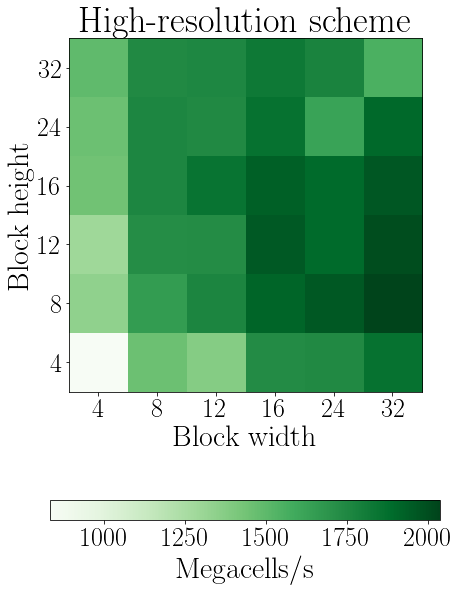

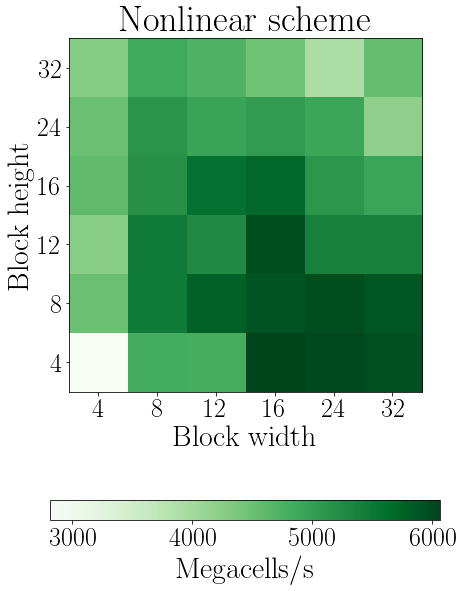

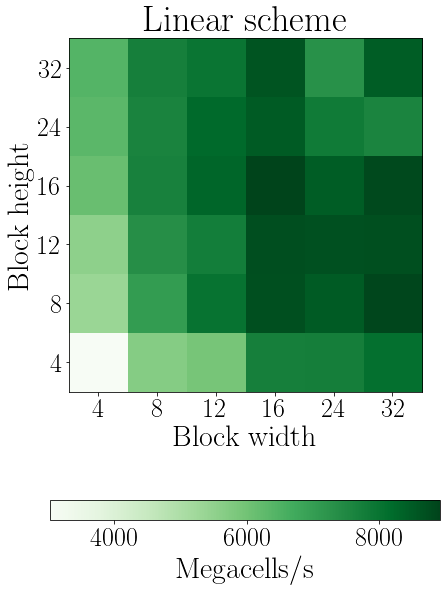

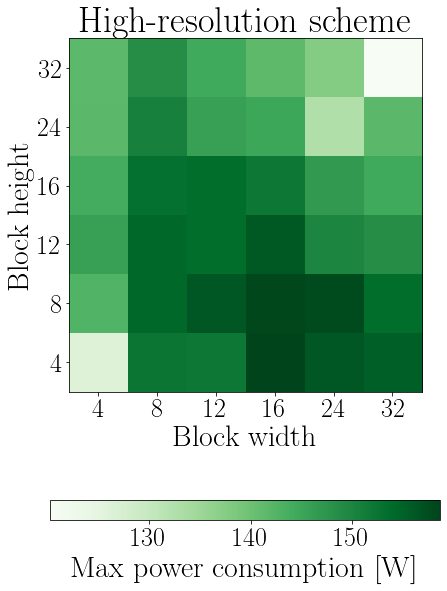

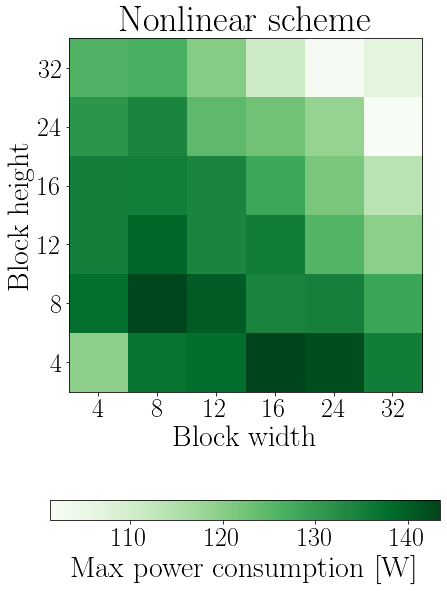

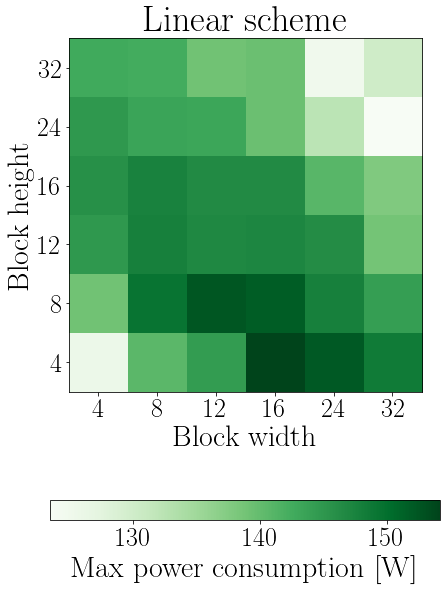

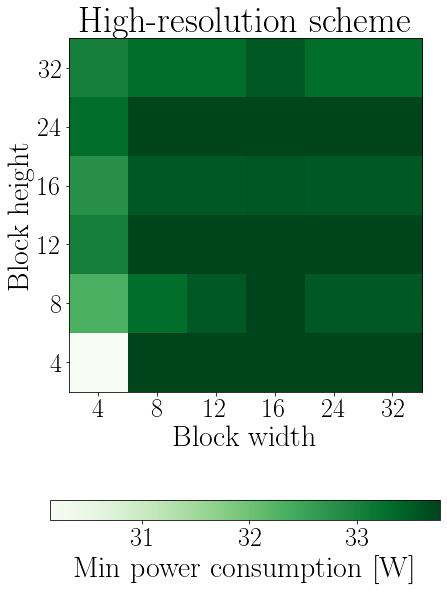

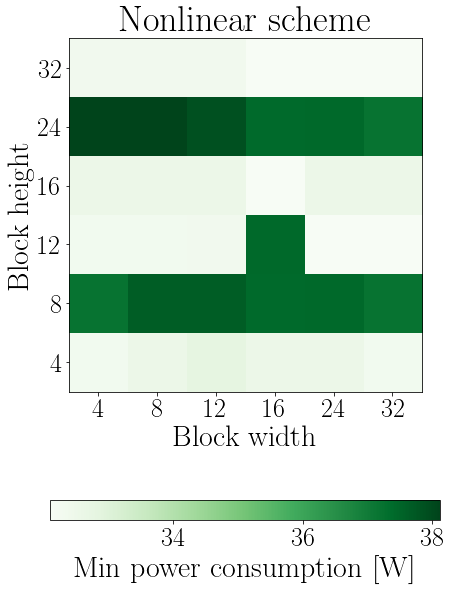

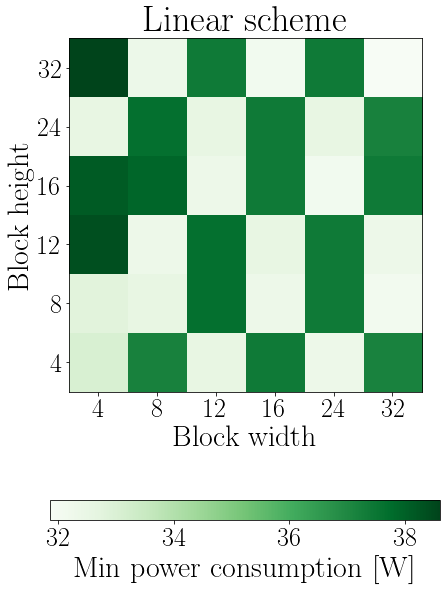

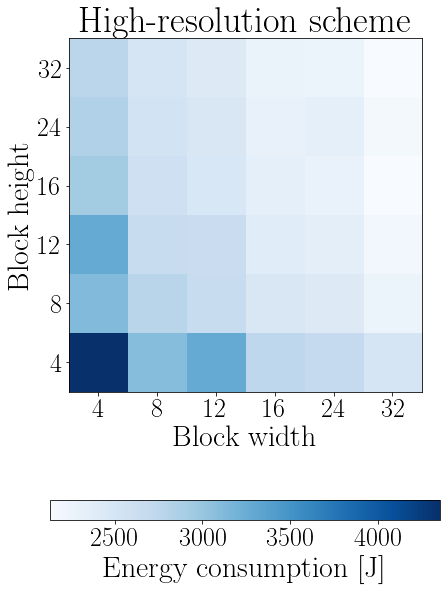

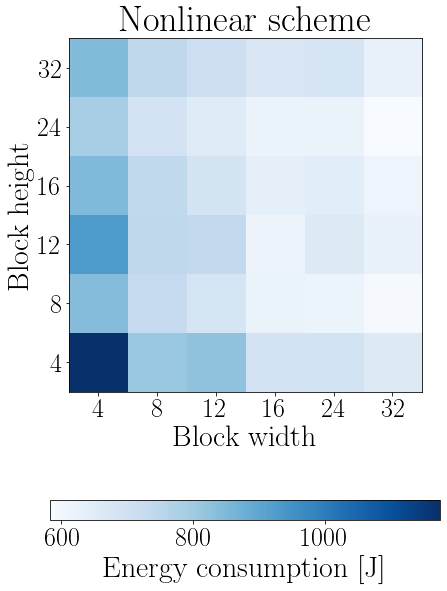

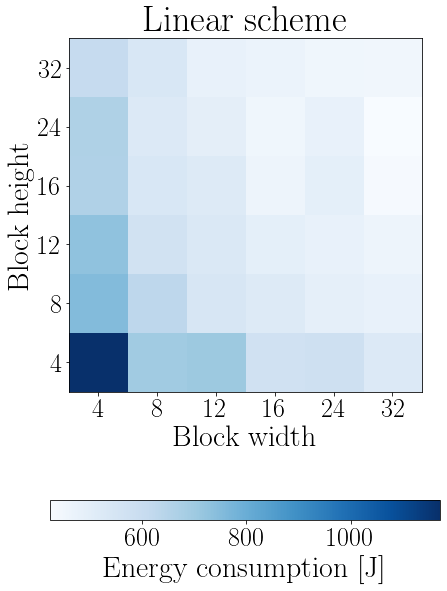

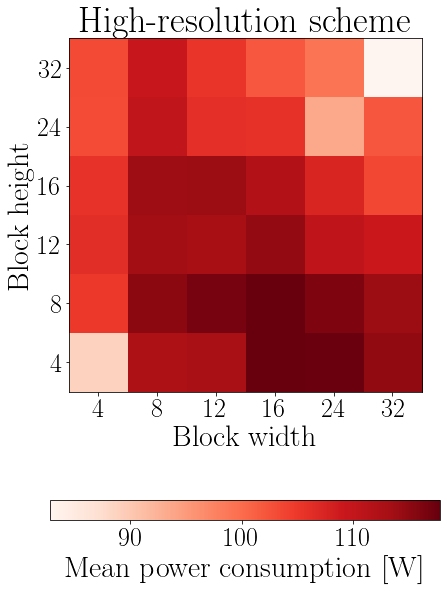

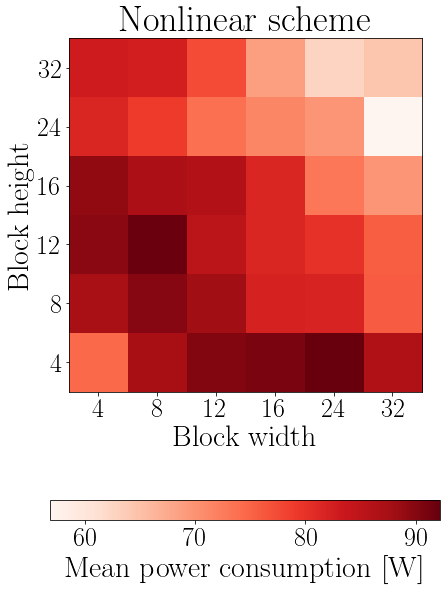

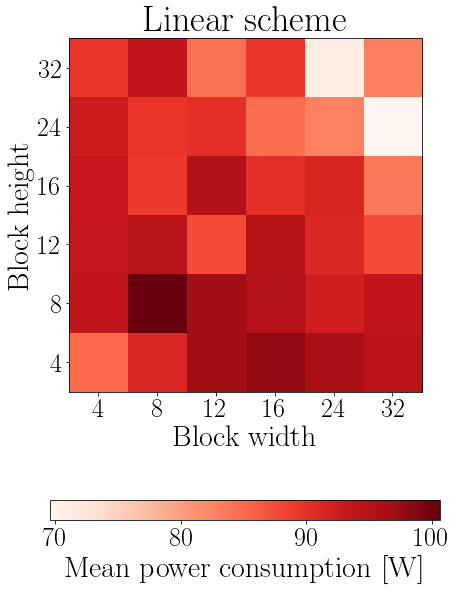

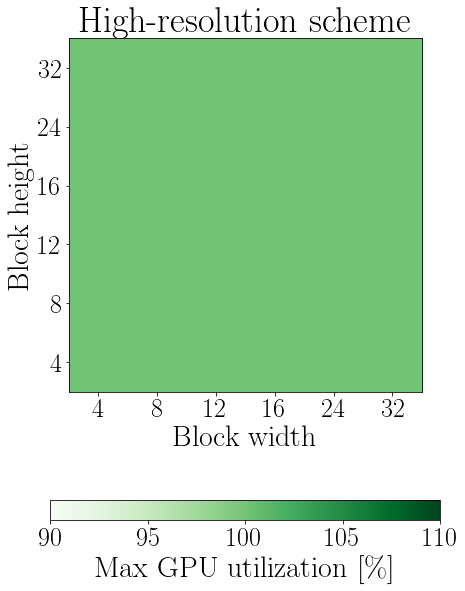

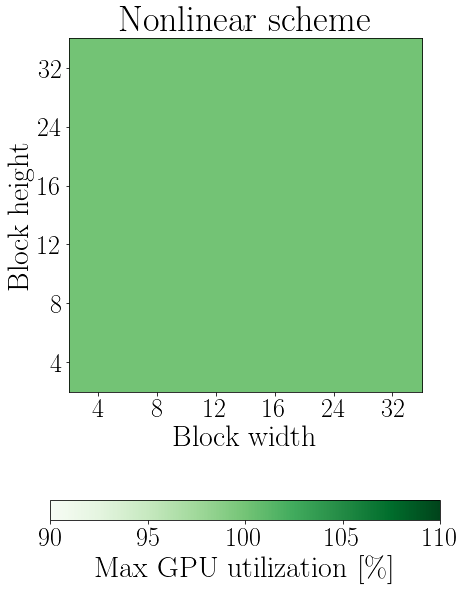

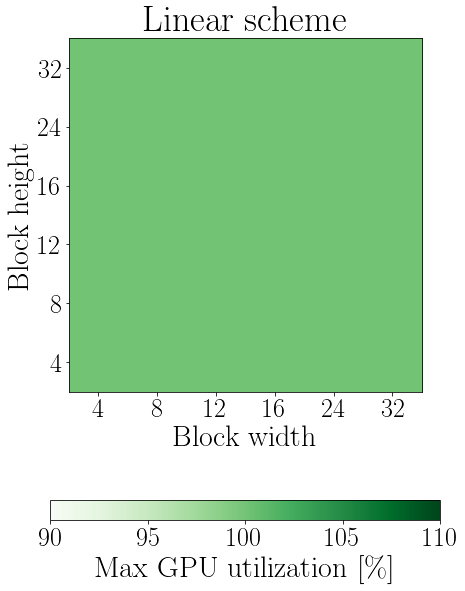

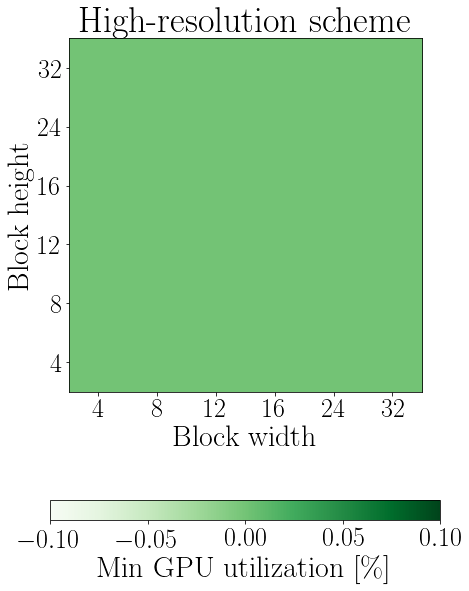

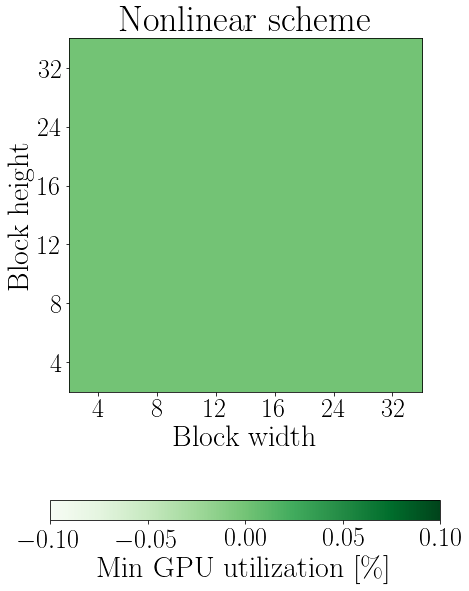

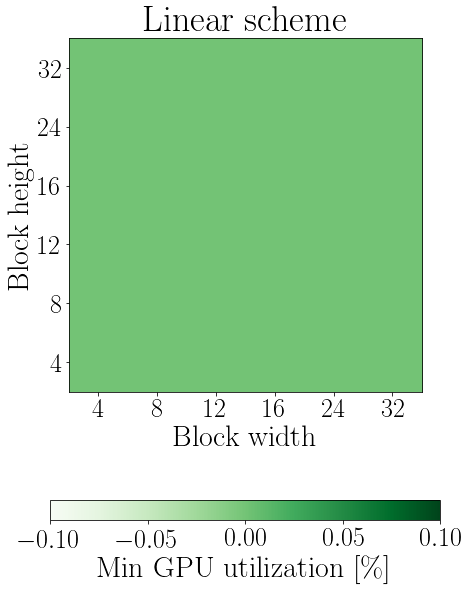

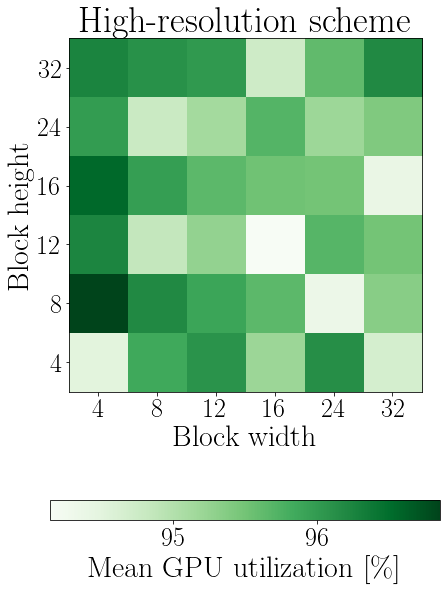

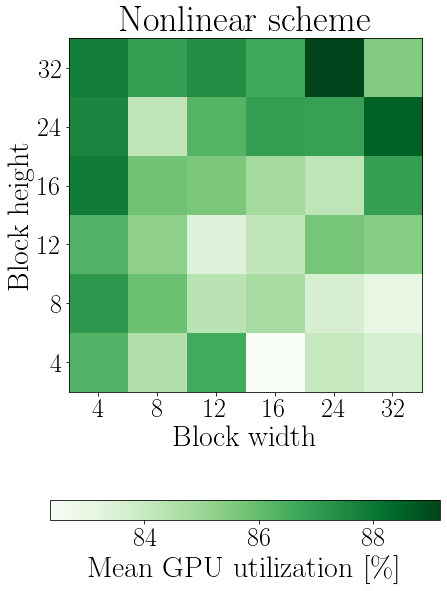

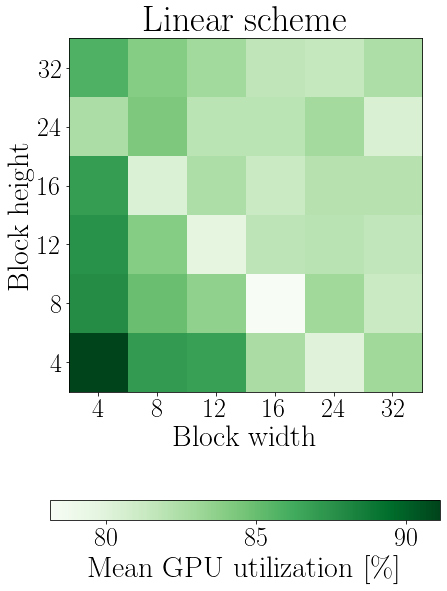

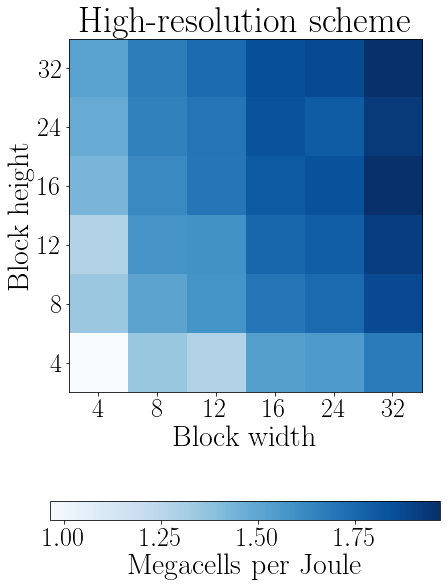

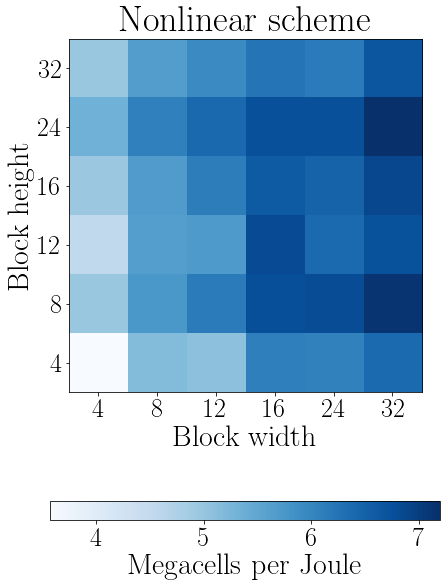

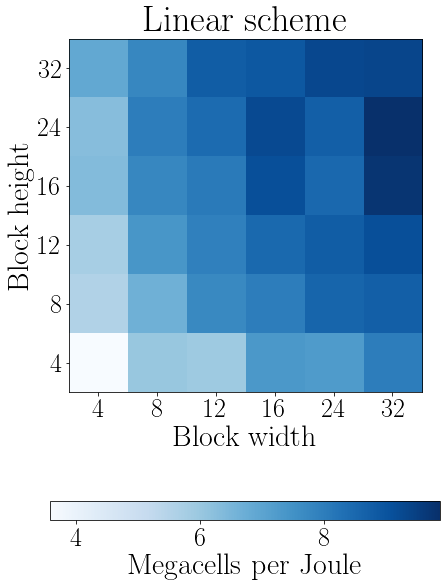

In [7]:
simulators = np.unique(df['simulator'])
block_widths = np.unique(df['block_width'])
block_heights = np.unique(df['block_width'])

print(block_widths)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#fields = ['simulator', 
#          'block_width', 'block_height', 'megacells',
#          'max_temperature', 'min_temperature', 'cumsum_temperature']
#          
#labels = ['simulator', 
#          'block_width', 'block_height', 'Megacells/s',
#          'Max temperature [C]', 'Min temperature [C]', 'Accumulated temperature [Cs]']


def plot_result(all_df, field_id, colorbar_on_the_side=False):
    
    assert(field_id > 2), 'field_id must take values between 3 and '+str(len(labels)-1)
    assert(field_id < len(labels)), 'field_id must take values between 3 and '+str(len(labels)-1)
             
        
    if dataframe_columns[field_id] in ['max_temperature', 'min_temperature', 'cumsum_temperature']:
        print('Skipping plot of ' + str(dataframe_columns[field_id]))
        return 
        
    print('Plotting ' + str(dataframe_columns[field_id]))
    
    for simulator in simulators:
        
        data = all_df[['simulator', 
                       'block_width', 'block_height', 
                       dataframe_columns[field_id]]].to_numpy()
        
        df = pd.DataFrame(index=block_widths, columns=block_heights)
        
        # Pick this simulator data only and sort into a dataframe
        columns = data[:,0] == simulator
        all_nan = True
        for record in data[columns]:
            block_width = record[1]
            block_height = record[2]
            values = np.float32(record[3])
            df[block_height][block_width] = values
            if not np.isnan(values):
                all_nan = False
            
        print(df)
        if all_nan:
            print('All values are NaN - nothing to plot')
            return

        maximum = np.nanmax(df.values)
        minimum = np.nanmin(df.values)
        mean = np.nanmean(df.values)
        print(df)
        print("Maximum={:.2f}".format(maximum))
        print("Minimum={:.2f}".format(minimum))
        print("Mean={:.2f}".format(mean))

        # Plot dataframe
        x = df.index.values.astype(np.int)
        y = df.columns.values.astype(np.int)
        z = np.transpose(df.values.astype(np.float32))
        
        cmap = cm.Greens
        if dataframe_columns[field_id] == 'mean_power':
            cmap = cm.Reds
        elif dataframe_columns[field_id] in ['total_power', 'megacells_per_joule']:
            cmap = cm.Blues
        
        fontsize=30
        if colorbar_on_the_side:
            fontsize = 22
        fig = None
        if colorbar_on_the_side:
            fig = plt.figure(figsize=(7,5))
        else:
            fig = plt.figure(figsize=(7,10))        
        ax = fig.add_subplot(111)
        img = ax.imshow(z, origin='lower', cmap=cmap, interpolation="None")

        plt.xticks( range(len(x)), x, fontsize=fontsize-4)
        ax.set_xlabel('Block width', fontsize=fontsize)
        plt.yticks( range(len(y)), y, fontsize=fontsize-4)
        ax.set_ylabel('Block height', fontsize=fontsize)

        cb = None
        if colorbar_on_the_side:
            cb = plt.colorbar(img)
        else:
            cb = plt.colorbar(img, orientation="horizontal", pad=0.2)
        cb.ax.tick_params(labelsize=fontsize-4)
        #cb.ax.set_ylabel('Megacells/s')#, rotation=270)
        cb.set_label(labels[field_id].replace('%', '\%'), fontsize=fontsize)#, labelpad=-40, y=0.45)


        fig_filename = dataframe_columns[field_id]+'_'+simulator+'.pdf'
        fig_file = os.path.join(folder_name, fig_filename)
        #plt.title(simulator + " [megacells/s]", fontsize=fontsize+6)
        
        title = 'Linear scheme'
        if simulator == 'CTCS':
            title = 'Nonlinear scheme'
        elif simulator == 'CDKLM':
            title = 'High-resolution scheme'
        
        plt.title(title, fontsize=fontsize+6)
        if colorbar_on_the_side:
            plt.tight_layout()
        fig.savefig(fig_file)
        print(fig_file)
            
for field_id in range(3,len(dataframe_columns)):
    plot_result(df, field_id) #, colorbar_on_the_side=True)

In [8]:
print(folder_name)

/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/met_p100/power_block_size_1


In [9]:
a1 = [1, 2,3]
a2 = [4,6,67]
a1+a2

[1, 2, 3, 4, 6, 67]

In [10]:
df_base_entries = {'simulator': 1,
                                   'block_width': 2,
                                   'block_height': 3,
                                   'megacells': 4}
df_base_entries.update({'something': 1234})
df_base_entries

{'simulator': 1,
 'block_width': 2,
 'block_height': 3,
 'megacells': 4,
 'something': 1234}

In [11]:
percent = ' 37 %'
percent = percent.replace(' ', '').replace('%', '')
int(percent)

37

In [12]:
read_smi_file('/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/prototypes/scripts/fbl_cuda_git_versions_desktop_nvidia-smi-reports/nvidia_smi_2019_08_23-16_30_34_38ff9b268a84e3f4a0805c67041b336f396e9a31.log')
pd.__version__

'0.25.0'